# KMC simulation of PLD with Deep Q Learning

In this versioin the state function is just the surface projection

In [33]:
!pip install keras

    100% |################################| 317kB 3.8MB/s ta 0:00:01
    100% |################################| 61kB 733kB/s ta 0:00:011
    100% |################################| 276kB 1.6MB/s ta 0:00:01
    100% |################################| 61kB 1.4MB/s ta 0:00:011
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [34]:
!pip install tensorflow-gpu

You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
import sys
import os
import numpy as np
import collections
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [8]:
#Writing some helper functions

def write_lattice_to_file(input_settings,position_vec, latt):
    #Write a new input lattice file
    #position_vec is the array containing positions of all of the atoms
    filename = input_settings['incfg_file'][0]
    new_latt_xyzs = list()
    
    for i in range(position_vec.shape[0]):
        new_latt_xyzs.append(list(['Ni', position_vec[i,0], position_vec[i,1],position_vec[i,2]]))

    new_latt = collections.OrderedDict()
    new_latt['nat'] = latt['nat']
    new_latt['box'] = latt['box']
    new_latt['xyzs'] = new_latt_xyzs

    write_latt(new_latt, filename)
    
    return 

def write_new_input_file(input_settings, filename):
    #Write a new input file, with settings laid out in the dictionary input_settings
    
    with open(filename, 'w') as fo:
        for key, val in input_settings.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)

def write_params_file(input_settings, new_parms):
    #IF you want to change parameters, use this function to write a new parameters file
    new_parms_file = input_settings['param_file']
    
    with open(new_parms_file, 'w') as fo:
        for key, val in new_parms.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)
            
def make_surface_proj(atom_box):
    #Given an atom box (matrix with 1s where atoms are), determine the surface projection
    
    surface_proj = np.zeros(shape=(atom_box.shape[0], atom_box.shape[1]))
    for i in range(surface_proj.shape[0]):
        for j in range(surface_proj.shape[1]):
            try:
                surface_proj[i,j] = np.max(np.where(atom_box[i,j,:]==1))
            except ValueError:
                surface_proj[i,j] = 0
    return surface_proj

def calc_roughness(surface_projection):
    #Calculate the roughness, given a surface projection
    N = surface_projection.shape[0]
    M = surface_projection.shape[1]
    zbar = np.mean(surface_projection)
    z_sum = 0
    for i in range(N):
        for j in range(M):
            z_sum+=((surface_projection[i,j] - zbar )**2)
    rms_roughness = np.sqrt((1.0/(N*M))*z_sum)
    return rms_roughness

def get_state_reward(sim_model):
    '''Given an input of the simulation model this function returns the state and reward'''
    #To get the final state put atoms into atom box
    arr = sim_model.kmc.get_conf()
    arr_1 = np.array(arr[0])
    full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
    for i,j,k in arr_1:
        full_atom_box[i,j,k]=1
        
    surface_proj = make_surface_proj(full_atom_box)
    rms_val = calc_roughness(surface_proj)
    
    return surface_proj, -1*rms_val

def run_sim_with_chosen_action(s,action,new_rates, verbose=False):
    #Given simulation model and the action, update the rate and continue running the simulation
    
    new_updated_rates = [new_rates[action[0]], new_rates[action[1]], new_rates[action[2]]]
    
    s.update_rate(np.array(new_updated_rates), verbose=verbose)
    
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99))
    
    #Now get the state and reward
    state, reward = get_state_reward(s)
            
    return state, reward, s,end_flag

In [9]:
#Need to hold the state in memory and hten 

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
sys.path.append('..') #/Users/l2v/work/kmcsim

Import kmc simulation tools

In [12]:
from kmcsim.buildtools import make_fcc, write_latt
from kmcsim.sim import KMCModel
from kmcsim.sim import EventTree
from kmcsim.sim import RunSim

Working directory (inputs, outputs)

In [13]:
wdir = '../data/working'

In [14]:
#cat ../data/working/params

Set up simulation box and initial configuration of the substrate (with atoms filling the whole box)

In [15]:
# make substrate: perfect FCC lattice of given dimensions
box = [16, 32, 4]
latt = make_fcc(box)

In [16]:
# extend the box in the z-direction to make space for new layers to grow
latt['box'][3] = 12

In [17]:
# write initial configuration to xyz file in the working directory
write_latt(latt, os.path.join(wdir,'ni.xyz'))

In [18]:
sim = RunSim()
sim.read(os.path.join(wdir,'kmc.input'))
sim.init_sim()
sim.run()

time, iteration, number of atoms
(0.0, 0, 2048)
(5.00286043281086, 137, 2176)
(10.068404440636249, 257, 2272)
(15.100303559598874, 391, 2368)
(20.1259124174662, 560, 2475)
(25.145502021274304, 720, 2589)
(30.155230559743316, 937, 2733)
(35.175637706017106, 1136, 2861)
(40.17958787969066, 1340, 2987)
(45.18356107775941, 1546, 3131)
(50.20659497879734, 1759, 3267)
(55.21158242961858, 1949, 3389)
End of simulation
(60.036706613210384, 2136, 3510)


current rates:[0.05 0.05 0.01] 
new rates:[0.12 0.12 0.12]
('kmc step:', 0)
current rates:[0.05 0.05 0.01] 
new rates:[0.14 0.12 0.12]
('kmc step:', 0)
current rates:[0.05 0.05 0.01] 
new rates:[0.16 0.12 0.12]
('kmc step:', 0)


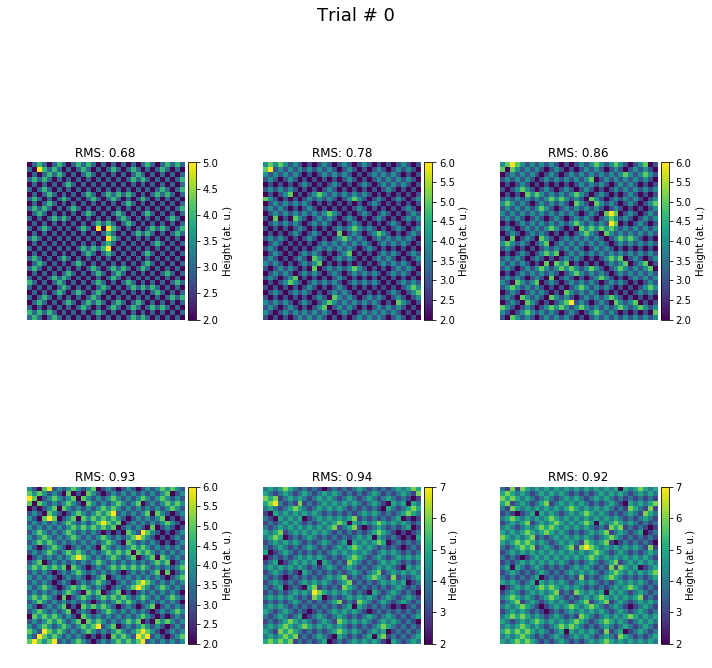

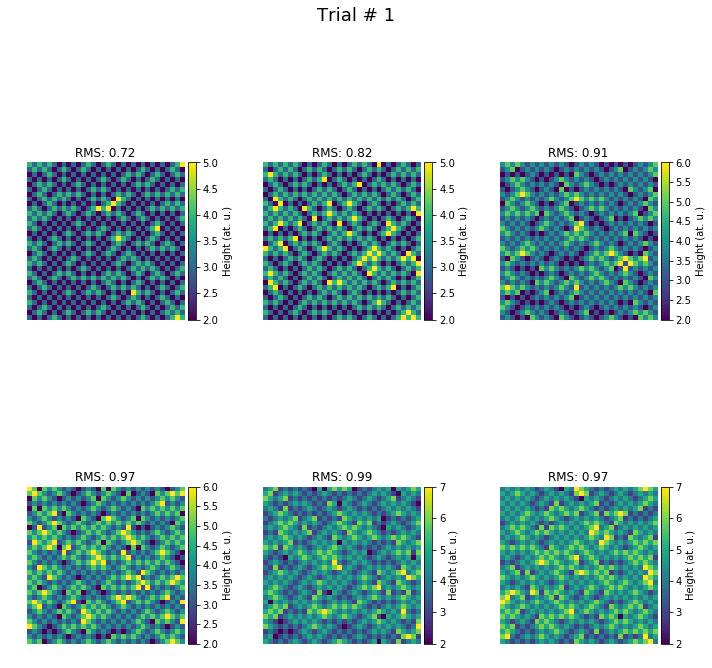

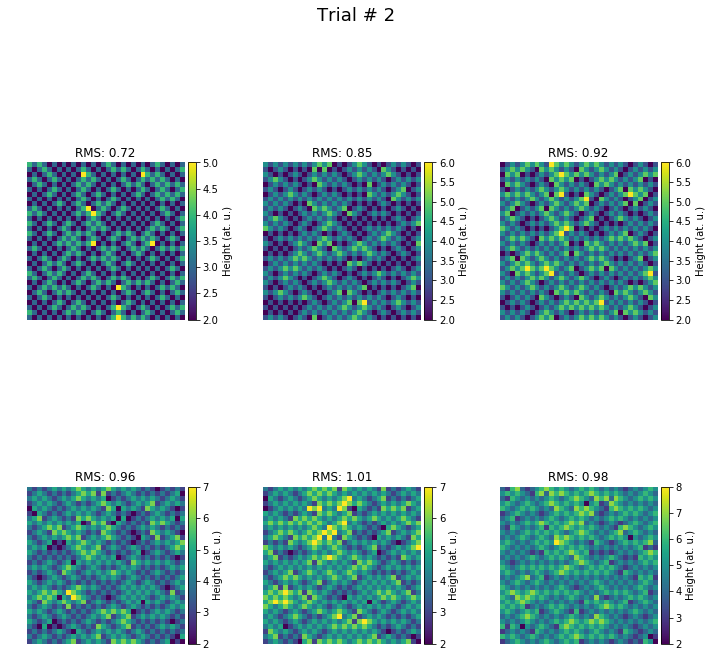

In [20]:
drates = [0.12, 0.14, 0.16]
deprates = [0.12, 0.12, 0.12]

arrs = []
roughness_values = []
for k in range(3):

    sim = RunSim()
    sim.read(os.path.join(wdir,'kmc.input'))
    sim.init_sim()
    sim.update_rate(np.array([drates[k], deprates[k], deprates[k]]))
    fig, axes = plt.subplots(figsize = (10,10), nrows=2,ncols=3)
    fig.suptitle("Trial # {}".format(k), fontsize = 18, y = 1.05)
    for ind, ax in enumerate(axes.flat):

        sim.run_to_next_step()
        arr = sim.kmc.get_conf()
        arr_1 = np.array(arr[0])
        arrs.append(arr_1)
        full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
        for i,j,k in arr_1:
            full_atom_box[i,j,k]=1

        surface_proj = make_surface_proj(full_atom_box)
        rms_val = calc_roughness(surface_proj)
        roughness_values.append(rms_val)
        im1 = ax.imshow(surface_proj)
        #plt.colorbar()
        ax.set_title('RMS: ' + str(np.round(rms_val,2)));
        ax.axis('off')
        #ax.set_yticklabels('')
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb = fig.colorbar(im1, cax=cax, orientation='vertical')
        cb.ax.set_ylabel('Height (at. u.)')
        
    fig.tight_layout(h_pad = 1.12, w_pad = 1.12)
    


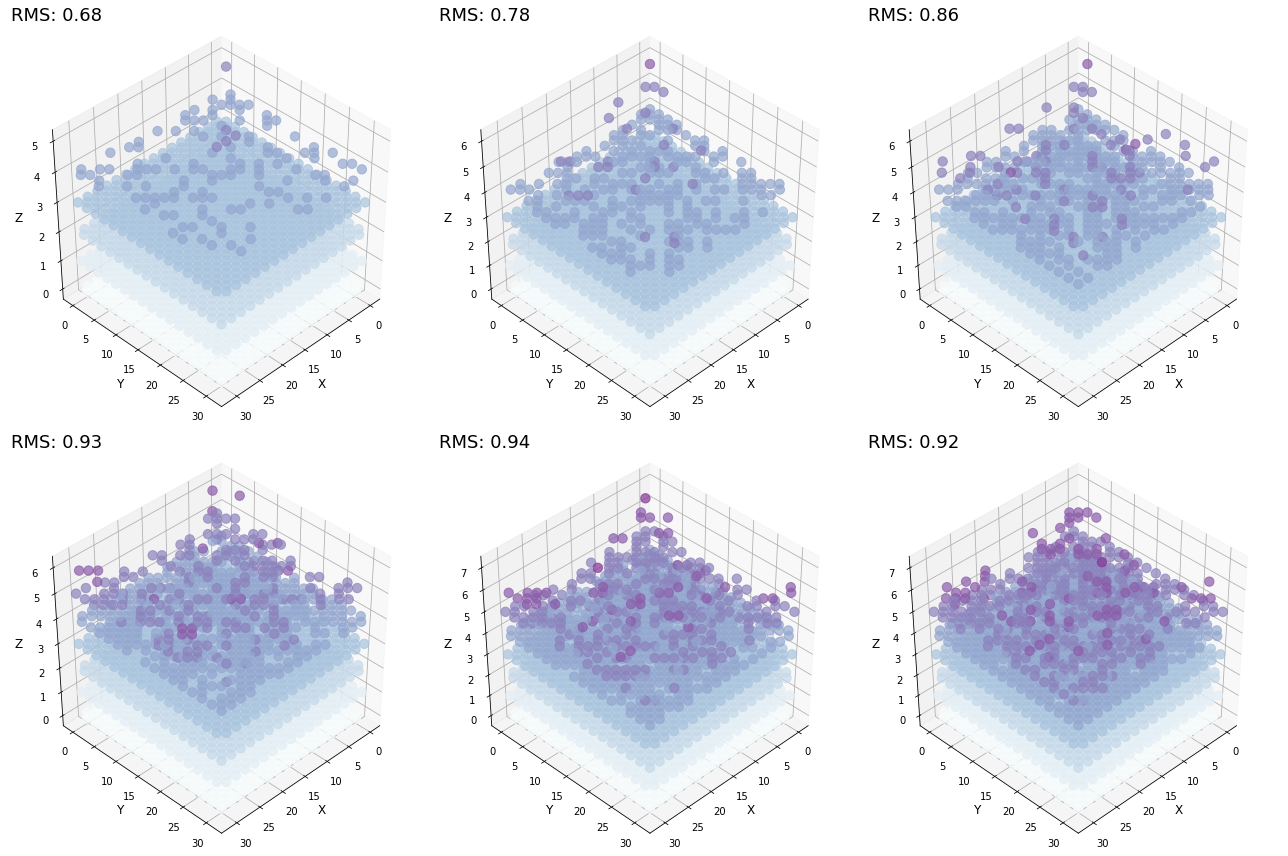

In [21]:
colors = plt.cm.get_cmap('BuPu', arr_1[:,2].max()*1.25)
arr_1 = arrs[5]

fig2, axes2 = plt.subplots(figsize = (18,12),nrows=2,ncols=3,subplot_kw=dict(projection='3d'))
for ind, ax in enumerate(axes2.flat):
    roughness_val = np.round(roughness_values[ind],2)
    arr_1 = arrs[ind]
    #ax = fig.add_subplot(111, projection='3d')
    ax.scatter(arr_1[:,0],arr_1[:,1],arr_1[:,2],s=88, alpha = 0.7, c = colors(arr_1[:,2]) )
    ax.view_init(40, 45)
    ax.set_xlabel('X', fontsize = 12)
    ax.set_ylabel('Y', fontsize = 12)
    ax.set_zlabel('Z', fontsize = 12)
    ax.set_title('RMS: {}'.format(roughness_val), loc = 'left', fontsize = 18)
fig2.tight_layout()

Text(0.5,1,'Roughness as Func. of Deposition Rates')

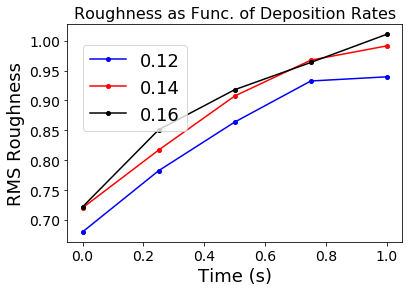

In [22]:
time_vec = np.linspace(0,1,5)

fig, axes = plt.subplots()
axes.plot(time_vec, roughness_values[:5], color = 'b', markersize = 4, marker = 'o',label = drates[0])
axes.plot(time_vec, roughness_values[6:11], color = 'r', markersize = 4, marker = 'o',label = drates[1])
axes.plot(time_vec, roughness_values[12:-1], color = 'k', markersize = 4, marker = 'o',label = drates[2])
axes.set_xlabel('Time (s)', fontsize = 18)
axes.set_ylabel('RMS Roughness', fontsize = 18)
fig.legend(loc=[0.2, 0.55], fontsize= 18)
for tickx in axes.xaxis.get_major_ticks():
    tickx.label.set_fontsize(14) 
for ticky in axes.yaxis.get_major_ticks():
    ticky.label.set_fontsize(14) 
axes.set_title('Roughness as Func. of Deposition Rates', fontsize = 16)
    

# Reinforcement Learning Trial

In [35]:
#Set up the neural network model. Input: atom position box. Output: 
#Choose out of 3  rates ([0.05, 0.1, 0.15]) for all three events. Vector of length 9.
from keras import Sequential
from keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Conv3D, MaxPool3D, Flatten
from keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, activation='relu', kernel_size = (3,3), strides = (1,1), batch_input_shape=(1,32,32,1)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(16, activation='relu', kernel_size = (3,3), strides = (1,1)))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.build()
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (1, 30, 30, 32)           320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (1, 15, 15, 32)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 13, 13, 16)           4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (1, 6, 6, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (1, 576)                  0         
_________________________________________________________________
dense_1 (Dense)              (1, 128)                  73856     
_________________________________________________________________
dense_2 (Dense)              (1, 128)                  16512     
__________

In [67]:
num_episodes = 150
y = 0.30
eps = 0.8
decay_factor = 0.99
r_avg_list = []
dep_rates = [0.10, 0.20, 0.30]
action_chosen = []

s = RunSim()
s.read(os.path.join(wdir,'kmc.input')) #Initialize the simulation with this input

target_roughness = 0.70

for episode in range(num_episodes):
    t0 = time()
    if episode%10==0:
        print('Episode No. {}'.format(episode))
        
    counter = 0
    r_sum = 0
   
    #for each episode start from the beginning, i.e. initialize a new simulation with default parameters
    
    s.init_sim()
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99)) #Run the simulation from the initial conditions
    
    while end_flag!=1:
        
        eps *= decay_factor
        #eps = max(eps, 0.05) #maintain some semblence of exploration ;)
        #Get the state and reward
        state, reward  = get_state_reward(s)

        #Choose an action
        if np.random.random() < eps:
            action = [np.random.randint(0, 3), np.random.randint(0, 3), np.random.randint(0, 3)]
            #Need to choose three actions at the same time.
        else:
            action = [np.argmax(model.predict(state[None,:,:,None])[0][:3]),
                      np.argmax(model.predict(state[None,:,:,None])[0][3:6]),
                      np.argmax(model.predict(state[None,:,:,None])[0][6:])]
            
        #Now run the simulation from the new state with the new action
        #Returns the state function and kmcmodel
        old_rates = s.kmc.etree.rates
        s_new, reward_new, kmc_model, end_flag = run_sim_with_chosen_action(s,action, dep_rates)
        
        reward_new = reward_new - reward 
        
        target = reward_new + y * np.max(model.predict(s_new[None,:,:,None]))
        target_vec = model.predict(state[None,:,:,None])[0]
        target_vec[action] = target
        
        #print("Action Number: {}, Deposition Rate: {}".format(counter, dep_rates[action]))
        
        model.fit(state[None,:,:,None], target_vec.reshape(-1, 9), epochs=1, verbose=0)
        s = kmc_model
        counter+=1
        r_sum += reward_new
        
        
        action_chosen.append(action)
    t1 = time()    
    print("Took {} s".format(np.round(t1-t0, 4)))
        
    r_avg_list.append(r_sum)


Episode No. 0
Took 43.8737 s
Took 43.1049 s
Took 44.8624 s
Took 39.4056 s
Took 37.4672 s
Took 38.595 s
Took 41.0217 s
Episode No. 10
Took 39.2476 s
Took 37.4309 s
Took 38.9736 s
Took 38.2304 s
Took 38.588 s
Took 39.7622 s
Took 38.6889 s
Took 39.3126 s
Took 39.0631 s
Took 38.2643 s
Episode No. 20
Took 38.6511 s
Took 38.6035 s
Took 39.8931 s
Took 38.4304 s
Took 38.9829 s
Took 39.3034 s
Took 39.3344 s
Took 39.8252 s
Took 40.0971 s
Took 39.3394 s
Episode No. 30
Took 39.5972 s
Took 39.5802 s
Took 39.7566 s
Took 40.6185 s
Took 39.5432 s
Took 39.5442 s
Took 39.2514 s
Took 38.861 s
Took 39.3983 s
Took 39.4471 s
Episode No. 40
Took 40.0852 s
Took 39.2681 s
Took 39.9704 s
Took 39.576 s
Took 38.1373 s
Took 38.1506 s
Took 38.8279 s
Took 39.7267 s
Took 39.7406 s
Took 39.2201 s
Episode No. 50
Took 39.4335 s
Took 37.8154 s
Took 37.7152 s
Took 38.596 s
Took 38.0489 s
Took 39.2268 s
Took 38.2633 s
Took 39.6608 s
Took 38.6363 s
Took 38.4069 s
Episode No. 60
Took 38.7369 s
Took 39.7316 s
Took 39.4825 s
T

In [68]:
target

0.001626406330615282

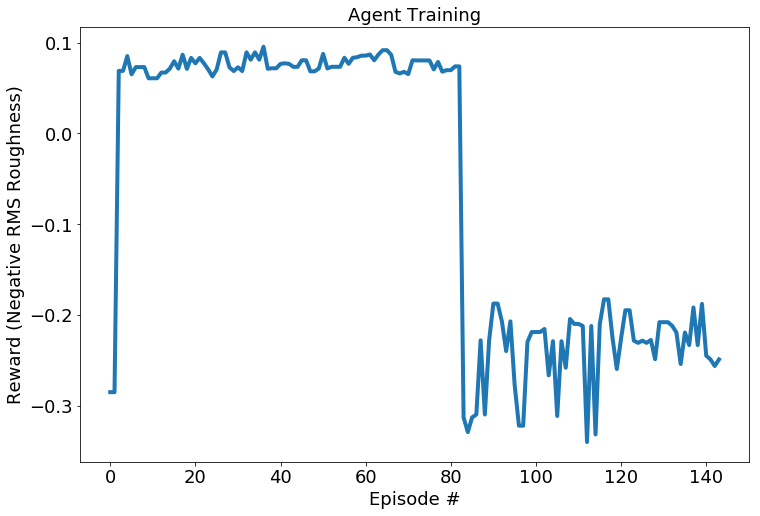

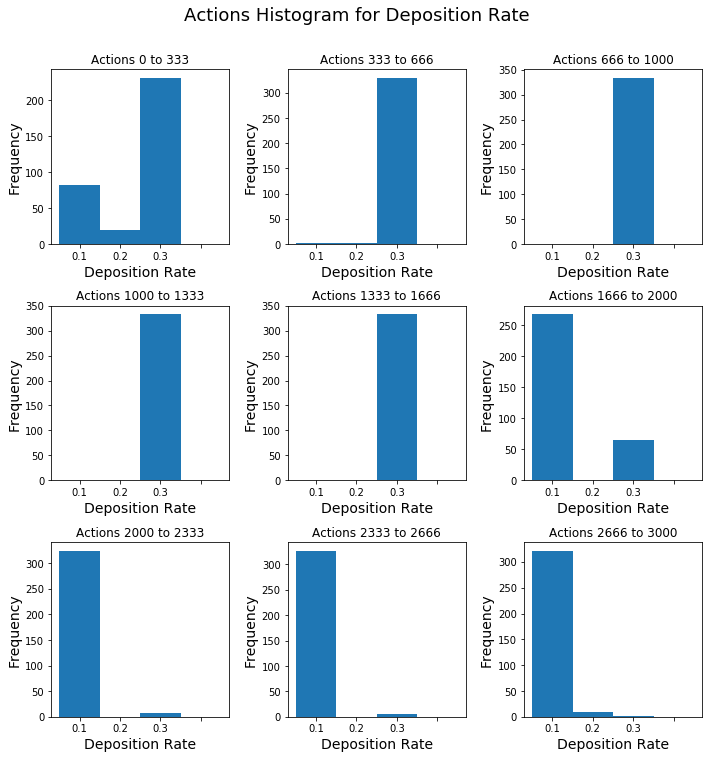

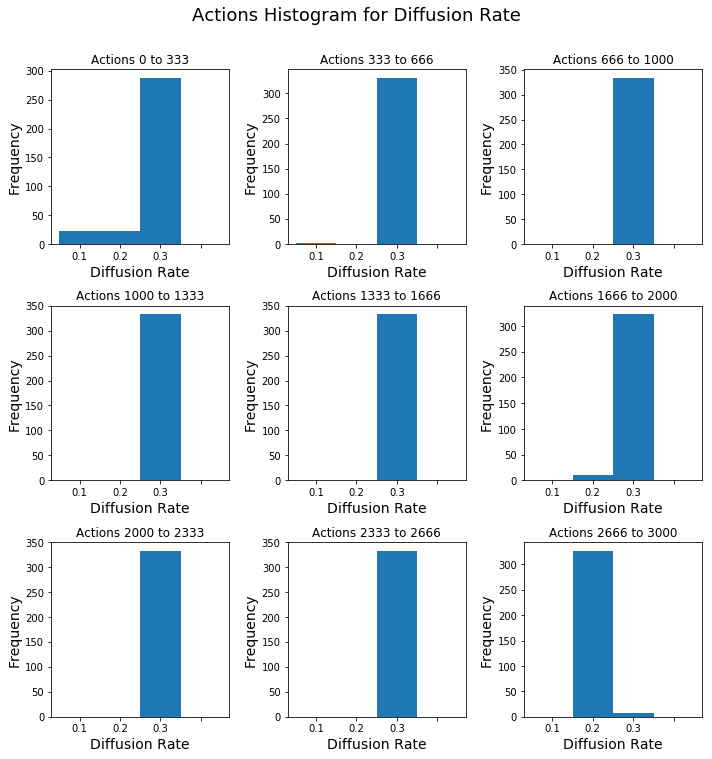

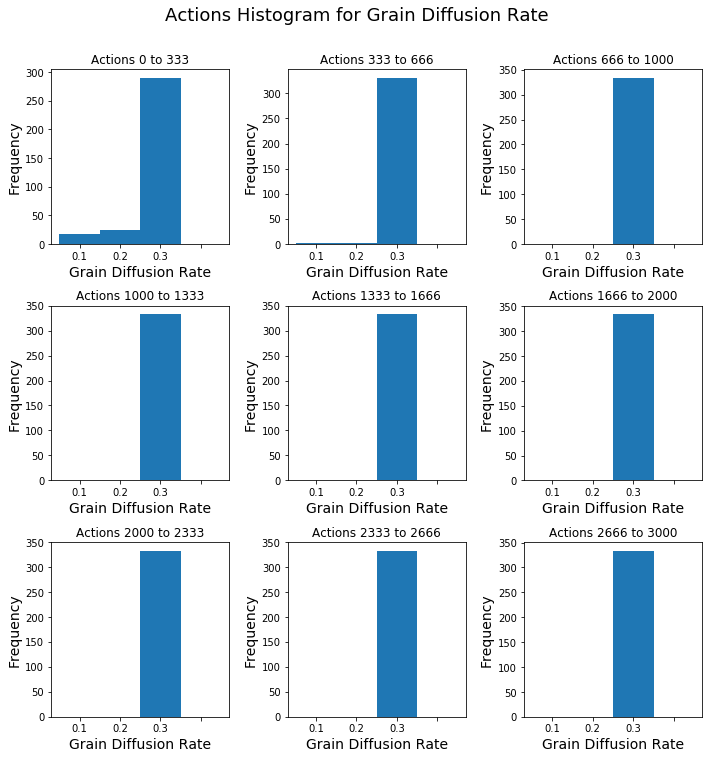

In [70]:
from scipy.signal import wiener, medfilt

kernel_size = 3

plt.figure(figsize = (12,8))
plt.plot(medfilt(r_avg_list, kernel_size= kernel_size)[kernel_size:-kernel_size], linewidth = 4)
plt.title('Agent Training', fontsize = 18)
plt.xlabel('Episode #', fontsize = 18)
plt.ylabel('Reward (Negative RMS Roughness)', fontsize = 18)
plt.xticks(fontsize =18)
plt.yticks(fontsize =18)
plt.savefig('reward_per_episode_dep_sp.png', dpi = 300)

#Let's take a look at how the actions change over time: consider 9 increments

total_actions = len(action_chosen)
segments = np.linspace(0,total_actions, 10)

rate_labels = ['Deposition Rate', 'Diffusion Rate', 'Grain Diffusion Rate']

for i in range(3):
    fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(10,10))
    for ind, ax in enumerate(axes.flat):
        seg_start = int(segments[ind])
        seg_finish = min(int(segments[ind+1]),total_actions)
        act_segment = np.array(action_chosen[seg_start:seg_finish])[:,i] 
       
        ax.hist(act_segment, bins = [0,1,2,3,4])
        ax.set_xlabel(rate_labels[i], fontsize = 14)
        ax.set_ylabel('Frequency', fontsize = 14)
        ax.set_title('Actions {} to {}'.format(seg_start, seg_finish), fontsize = 12 )
        ax.set_xticks([0.5,1.5,2.5,3.5])
        ax.set_xticklabels(dep_rates)

    fig.suptitle('Actions Histogram for ' + rate_labels[i], fontsize = 18, y = 1.05)
    fig.tight_layout()
    fig.savefig('actions_histogram_dep_sp_'+str(i) +'.png', dpi = 300)

#### things to try
#1. 2d conv net with surface projection
#2. flattened array with xyz values instead of whole box
#3. find time taken per simulation (as above)

1. distributed learning.
2. try more sophisticated algo.
3. keep on getting closer to PLD...


In [ ]:
#Next goal: modify reward function to get the roughness at a particular value.